In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data loading, cleanup, indexing, getting data ready for visualisation

In [2]:
df = pd.read_csv('perrin-freres-monthly-champagne-.csv')

In [3]:
df.isnull().sum()

Month                                                     1
Perrin Freres monthly champagne sales millions ?64-?72    2
dtype: int64

In [4]:
df.describe()

,Perrin Freres monthly champagne sales millions ?64-?72
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


In [5]:
# changing column names and deleting nan values from the bottom 2 entries

In [6]:
df.dropna(inplace=True)
df.columns = ['month', 'sales']

#### convert month to index and to datetime

In [7]:
df['month'] = pd.to_datetime(df['month'])
df.set_index('month', inplace=True)

In [8]:
df.head()

,sales
month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


# Visualisation 

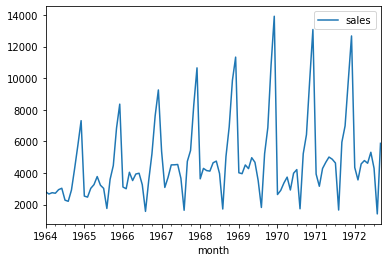

In [9]:
df.plot()

In [10]:
# Can see strong seasonality and also a very small upward trend. This can be confirmed with Dikey Fuller Test

In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
test_result = adfuller(df['sales'])
print('Ad test statistics -',test_result[0])
print('p-value -',test_result[1])
print('lag used -',test_result[2])
print('Number of observations used -', test_result[3])

Ad test statistics - -1.8335930563276237
p-value - 0.3639157716602447
lag used - 11
Number of observations used - 93


In [13]:
# pValue greater than 0.05, hence the data is not stationary

#### Diffrencing

In [14]:
df['sales_diffrence_one'] = df['sales'] - df['sales'].shift(1)
df['seasonal_diffrence_one'] = df['sales'] - df['sales'].shift(12)

In [15]:
df.head(15)

,sales,sales_diffrence_one,seasonal_diffrence_one
month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
1964-06-01,3036.0,90.0,NaN
1964-07-01,2282.0,-754.0,NaN
1964-08-01,2212.0,-70.0,NaN
1964-09-01,2922.0,710.0,NaN


In [16]:
test_result = adfuller(df['seasonal_diffrence_one'].dropna())
print('Ad test statistics -',test_result[0])
print('p-value -',test_result[1])
print('lag used -',test_result[2])
print('Number of observations used -', test_result[3])

Ad test statistics - -7.626619157213163
p-value - 2.060579696813685e-11
lag used - 0
Number of observations used - 92


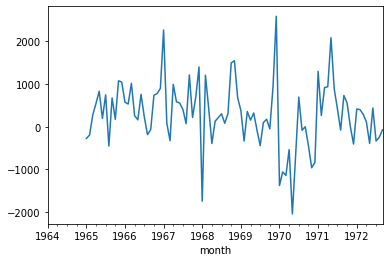

In [17]:
df['seasonal_diffrence_one'].plot()

p_value id less than 0.05 and also plot looks like the data is now stationary

#### Calculate p and q values

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

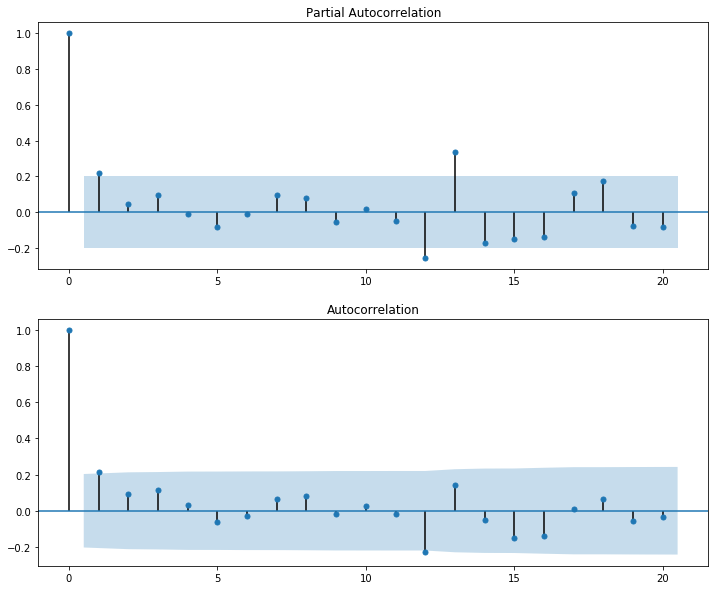

In [19]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211)
fig = plot_pacf(df['seasonal_diffrence_one'].dropna(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_acf(df['seasonal_diffrence_one'].dropna(), ax=ax2)

In [20]:
# p is (1,2) and q is (1,2)

### ARIMA

In [21]:
from statsmodels.tsa.arima_model import ARIMA

In [22]:
# Using data that is standardised but seasonal for prediction
model = ARIMA(df['sales'], order=(1,1,1))
model_fit = model.fit()
model_fit.summary()

C:\anaconda1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\anaconda1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.sales   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -951.126
Method:                       css-mle   S.D. of innovations           2227.262
Date:                Mon, 15 Jun 2020   AIC                           1910.251
Time:                        20:48:45   BIC                           1920.829
Sample:                    02-01-1964   HQIC                          1914.536
                         - 09-01-1972                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.7822     12.405      1.836      0.066      -1.532      47.096
ar.L1.D.sales     0.4343      0.089      4.866      0.000       0.259       0.609
ma.L1.D.sales    -1.0000      0.026    -38.503      0.000      -1.051      -0.949
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3023           +0.0000j            2.3023            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

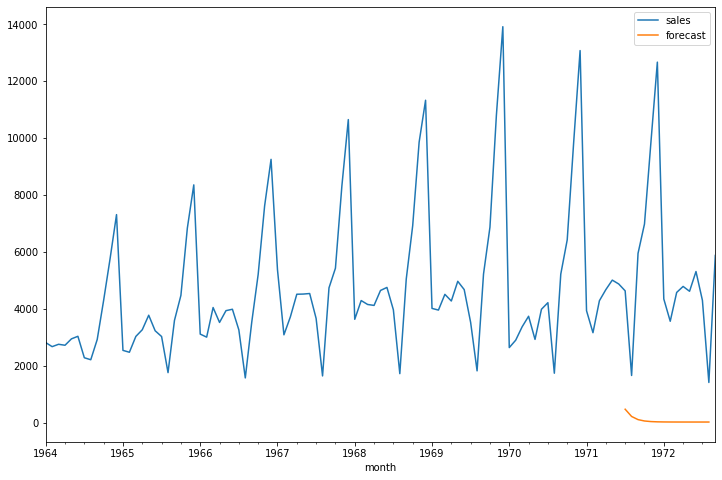

In [23]:
df['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
df[['sales','forecast']].plot(figsize=(12,8))

In [24]:
# As can be seen the forecast is not accurate.

In [25]:
# Now using data by taking out seasonality.
import statsmodels.api as sm

In [26]:
model = sm.tsa.statespace.SARIMAX(df['sales'], order=(1,1,1), seasonal_order=(1,1,1,12))
result = model.fit()

C:\anaconda1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\anaconda1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


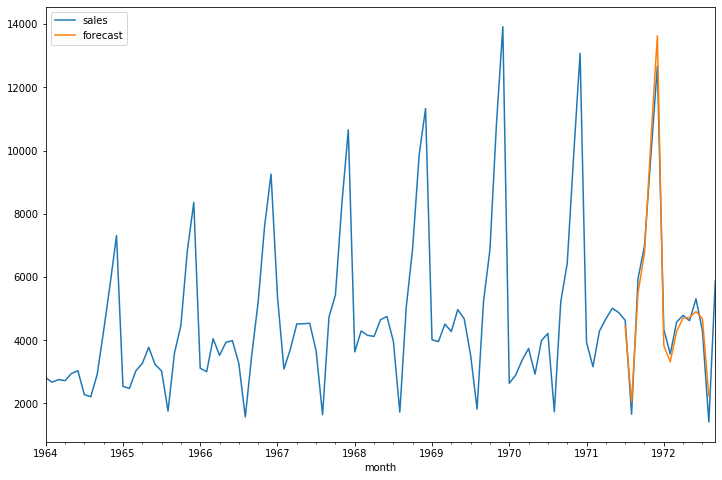

In [27]:
df['forecast']=result.predict(start=90,end=103,dynamic=True)
df[['sales','forecast']].plot(figsize=(12,8))

In [28]:
# Prediction now looks better and more accurate

In [29]:
# Predicting future sales

In [33]:
forecast_1 = result.forecast(steps=36)
df_forecast = pd.DataFrame(forecast_1)
df_forecast.columns = ['future_forecast']

In [34]:
new_df = pd.concat([df, df_forecast], axis=1)

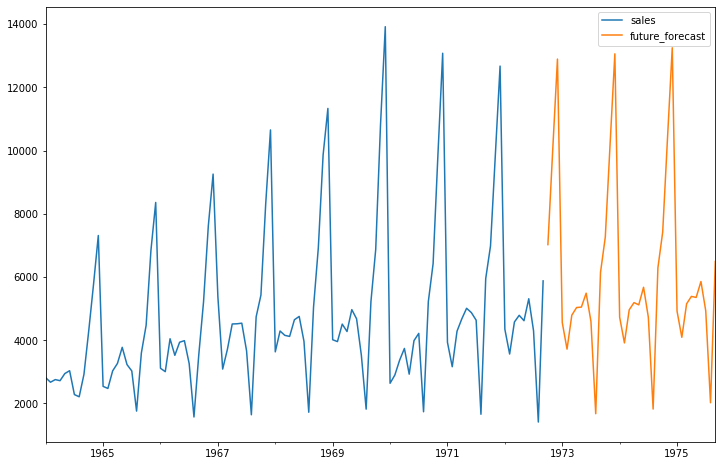

In [35]:
new_df[['sales','future_forecast']].plot(figsize=(12,8))

In [36]:
# Future forecast also look resonably accurate.

In [38]:
# new_df.tail(50)

,sales,sales_diffrence_one,seasonal_diffrence_one,forecast,future_forecast
1971-08-01,1659.0,-2974.0,-79.0,2050.747855,NaN
1971-09-01,5951.0,4292.0,730.0,5493.376775,NaN
1971-10-01,6981.0,1030.0,557.0,6752.038686,NaN
1971-11-01,9851.0,2870.0,9.0,10327.296978,NaN
1971-12-01,12670.0,2819.0,-406.0,13632.323850,NaN
1972-01-01,4348.0,-8322.0,414.0,3832.961857,NaN
1972-02-01,3564.0,-784.0,402.0,3313.097224,NaN
1972-03-01,4577.0,1013.0,291.0,4285.476511,NaN
1972-04-01,4788.0,211.0,112.0,4701.093067,NaN
1972-05-01,4618.0,-170.0,-392.0,4717.511780,NaN
